In [1]:
import pandas as pd
import spacy
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


import sys
sys.path.append("../..")
from util.author_vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes

In [2]:
test_data = pd.read_pickle('../../data/04c_Test_Set.pkl')

# SpaCy Vectors

SpaCy enables the creating vector representations for sequences. Those are visualized and evaluated here as a first baseline.

% TODO: - Look up model and ensure that meaning is included

Only the test set is used to have a reduced number of authors and enable better visualization. In the end, this will be comparable to the evaluation of the test set with the final model.

In [3]:
nlp = spacy.load("en_core_web_sm")

messages = test_data["message"].tolist()

vectors = []

docs = nlp.pipe(messages)

for doc in tqdm(docs):
    vectors.append(doc.vector)

## Centroids

In [4]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


In [5]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,1.110,1.377,1.676,1.528,1.115,1.743
1,0.000,0.000,1.224,1.628,1.374,1.223,1.245
2,0.000,0.000,0.000,1.713,1.445,1.095,1.503
3,0.000,0.000,0.000,0.000,2.569,2.063,2.449
4,0.000,0.000,0.000,0.000,0.000,1.315,0.983
5,0.000,0.000,0.000,0.000,0.000,0.000,1.455
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

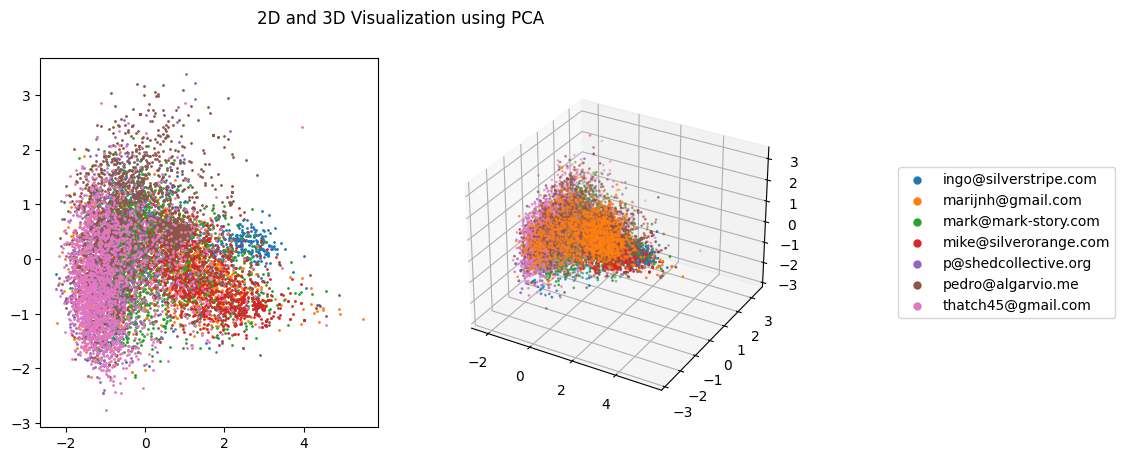

In [6]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

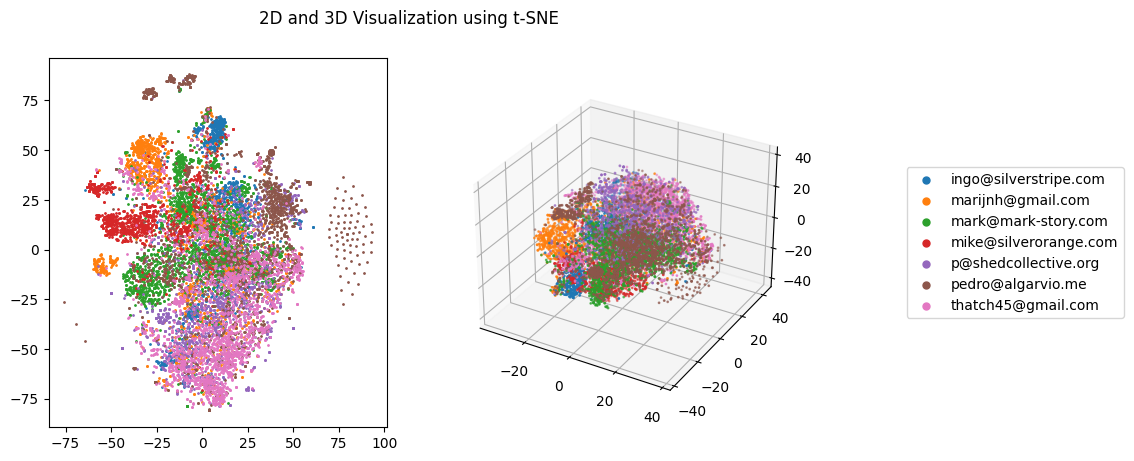

In [7]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

It can be seen that many SpaCy representations are similar and might be difficult to cluster. 

Anyways, below we try a density-based DBSCAN clustering and a centroid-based K-Means clustering to see if we can find clusters in the data.

## DBSCAN

% TODO: - Describe DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 5
10 Most common:
[(-1, 6060), (0, 4237), (1, 240), (2, 76), (3, 71)]


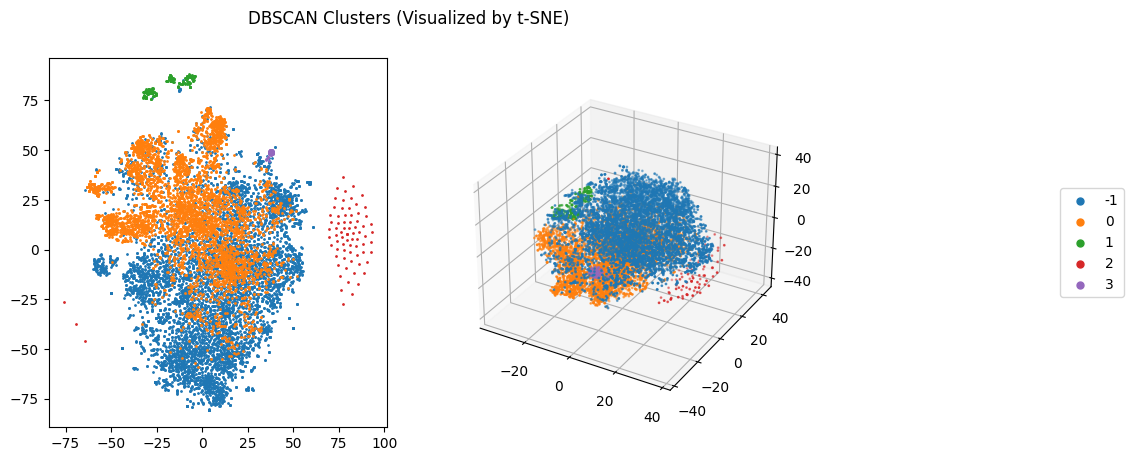

In [8]:
dbscan_model = DBSCAN(eps=2, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [9]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,6060.0,7.0,865.714286,"('thatch45@gmail.com', 1674)",84.0,72.142857,"('saltstack_salt', 2814)"
1,4237.0,7.0,605.285714,"('mark@mark-story.com', 1051)",62.0,68.338710,"('silverorange_swat', 1014)"
2,240.0,1.0,240.000000,"('pedro@algarvio.me', 240)",1.0,240.000000,"('saltstack_salt', 240)"
3,76.0,1.0,76.000000,"('pedro@algarvio.me', 76)",1.0,76.000000,"('saltstack_salt', 76)"
4,71.0,1.0,71.000000,"('pedro@algarvio.me', 71)",1.0,71.000000,"('saltstack_salt', 71)"


In [10]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2136.800000,3.400000,371.600000,29.800000,105.496313
std,2824.651076,3.286335,351.360292,40.195771,75.240299
min,71.000000,1.000000,71.000000,1.000000,68.338710
25%,76.000000,1.000000,76.000000,1.000000,71.000000
50%,240.000000,1.000000,240.000000,1.000000,72.142857
75%,4237.000000,7.000000,605.285714,62.000000,76.000000
max,6060.000000,7.000000,865.714286,84.000000,240.000000


In [11]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
Allowing success and error callbacks in refresh()
___
3) 
Better shell execution feedback from PDF extractor
___
4) 
Added iShouldSeeAButton assertion
___
5) 
MINOR Avoid reinitialising tabs (see #<I>)
___
6) 
Calling destructor on fatal errors

Avoids leaving TESTS_RUNNING.js around
___
7) 
MINOR Removed unnecessary 'actionsparams' class from LeftAndMain forms
___
8) 
Added getters for http client/response
___
9) 
BUGFIX Making HTML5 History support optional, so we can disable HTML4 hash change fallback
___
10) 
FIX Unset "underneath page" title when switching to "top" in "add page"
_________________

Number of messages in this class: 6060
Most common author:
('thatch45@gmail.com', 1674)
Most common project:
('saltstack_salt', 2814)



________________ Class 1 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no 

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(5, 2587), (0, 2369), (2, 2004), (4, 1399), (6, 1029), (3, 1012), (1, 284)]


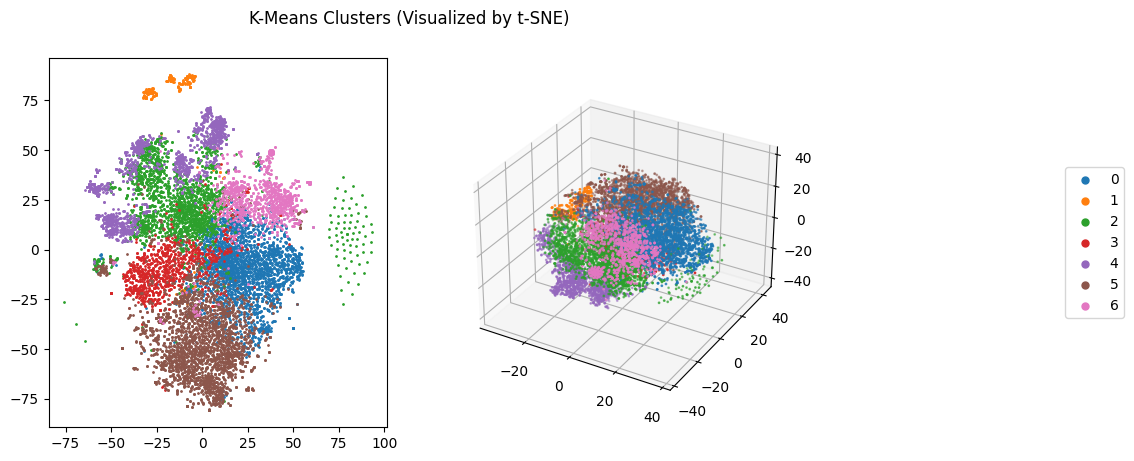

In [12]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [13]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,2369.0,7.0,338.428571,"('thatch45@gmail.com', 577)",74.0,32.013514,"('saltstack_salt', 1009)"
1,284.0,6.0,47.333333,"('pedro@algarvio.me', 247)",13.0,21.846154,"('saltstack_salt', 253)"
2,2004.0,7.0,286.285714,"('marijnh@gmail.com', 547)",44.0,45.545455,"('silverorange_swat', 450)"
3,1012.0,7.0,144.571429,"('mark@mark-story.com', 730)",39.0,25.948718,"('cakephp_cakephp', 669)"
4,1399.0,7.0,199.857143,"('mike@silverorange.com', 559)",32.0,43.718750,"('silverorange_swat', 559)"
5,2587.0,7.0,369.571429,"('thatch45@gmail.com', 1117)",60.0,43.116667,"('saltstack_salt', 1305)"
6,1029.0,7.0,147.000000,"('pedro@algarvio.me', 525)",53.0,19.415094,"('saltstack_salt', 531)"


In [14]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.857143,219.006803,45.000000,33.086336
std,830.135675,0.377964,116.920066,19.832633,11.062146
min,284.000000,6.000000,47.333333,13.000000,19.415094
25%,1020.500000,7.000000,145.785714,35.500000,23.897436
50%,1399.000000,7.000000,199.857143,44.000000,32.013514
75%,2186.500000,7.000000,312.357143,56.500000,43.417708
max,2587.000000,7.000000,369.571429,74.000000,45.545455


In [15]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
BackURL from request rather than URL param

No url mapping to $BackURL is defined anywhere in code,
so this condition would never be met. Setting BackURL
from form data makes more sense, and replicates the existing
logic from MemberLoginForm.
___
3) 
BUGFIX Always fall back to creating a new step (in case the session or request data is invalid)
___
4) 
Require config manifests in Core.php to avoid upgrading issues

They need to be present for the autoloader to rebuild
the manifest in the first place.
___
5) 
Fixed Behat scope for "I log in as"

Fixes an issues where multiple "Email" form fields are present
on a page, e.g. through a global login overlay in the header.
___
6) 
ENHANCEMENT Changed batch action logic, no longer updates applicable pages on batch action drop down selection, as this selection triggers the action itself. To be re